In [1]:
import matplotlib.pyplot as plt
import openfermion as of
from Hubbard_Model_nnn import *
import jax.numpy as jnp
from itertools import product
from jax import config
from numpy.polynomial.chebyshev import Chebyshev
from scipy.io import loadmat
import scipy.sparse as sp
import glob
config.update("jax_enable_x64", True)

# Set parameters.

In [2]:
# Parameters.
x_dimension = 2
y_dimension = 2
n_up = 2
n_down = 2

n_site = x_dimension * y_dimension

U = 4
t = 1.0
t_prime = 0.3
mu = 0.0

## Construct the reduced Hamiltonian.

In [3]:
def reduced_hubbard_model(U, indices):
    hopping_terms = fermi_hubbard_nnn(x_dimension, y_dimension, tunneling=t, nnn_tunneling=t_prime, coulomb=U, chemical_potential=mu, periodic=True)
    hopping_terms = of.get_sparse_operator(hopping_terms)
    H_hubbard = hopping_terms[jnp.ix_(indices, indices)].toarray()

    return H_hubbard

In [4]:
valid_indices = []
for bits in product('01', repeat= 2 * x_dimension * y_dimension):

    spin_up_indices = bits[::2]
    spin_down_indices = bits[1::2]

    if spin_up_indices.count('1') == n_up and spin_down_indices.count('1') == n_down:
        binary_str = ''.join(bits)
        valid_indices.append(int(binary_str, 2))

reduced_H_indices = jnp.array(valid_indices)

H_reduced = reduced_hubbard_model(U=U, indices=reduced_H_indices)
reduced_dim = len(H_reduced)
print('reduced_dim =', reduced_dim)

H_reduced_eigvals, H_reduced_eigvecs = jnp.linalg.eigh(H_reduced)
print(f"Eigenvalues:", jnp.round(H_reduced_eigvals[:8], 3))

reduced_dim = 36
Eigenvalues: [-5.657 -5.372 -4.374 -3.901 -3.901 -3.254 -1.716 -1.716]


In [72]:
U_sweep_ED = jnp.linspace(0, U, 80)

H_eigvals_sweep = []

for UU in U_sweep_ED:
    H = reduced_hubbard_model(U=float(UU), indices=reduced_H_indices)
    eigvals = jnp.linalg.eigvalsh(H)
    H_eigvals_sweep.append(eigvals)

H_eigvals_sweep = jnp.array(H_eigvals_sweep).T

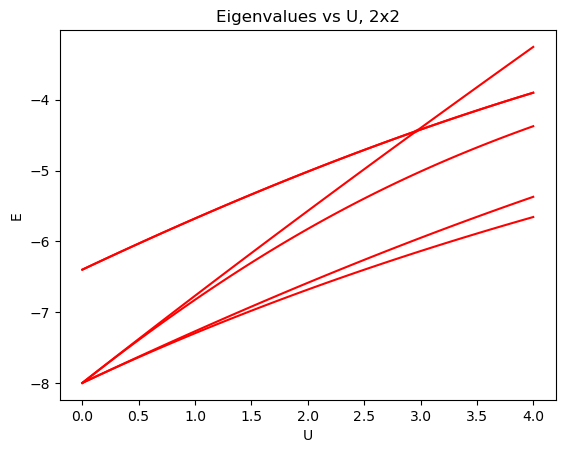

In [73]:
for band in range(6):
    plt.plot(U_sweep_ED, H_eigvals_sweep[band], 'red')


plt.xlabel('U')
plt.ylabel('E')
plt.title(f'Eigenvalues vs U, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

# plt.legend()
plt.show()

# Schur complement

In [7]:
def find_degeneracies(E0, tol=1E-10):

    sorted_indices = jnp.argsort(E0)
    sorted_E0 = jnp.array(E0)[sorted_indices]
    
    degeneracy_counts = []

    current_degeneracy = 1

    for i in range(1, len(sorted_E0)):
        if jnp.abs(sorted_E0[i] - sorted_E0[i - 1]) < tol:

            current_degeneracy += 1
        else:

            degeneracy_counts.append(current_degeneracy)
            current_degeneracy = 1

    degeneracy_counts.append(current_degeneracy)
    
    return degeneracy_counts

def degenerate_states(Hi, H0_eigvecs, degeneracy_counts):

    start_index = 0
    for i, count in enumerate(degeneracy_counts):
        
        P = H0_eigvecs[:, start_index:start_index+count]
        P_T = jnp.conj(P.T)
        Hi_proj = P_T @ Hi @ P

        Hi_eigvals, Hi_eigvecs = jnp.linalg.eigh(Hi_proj)
        Hi_eigvecs = P @ Hi_eigvecs
        
        if i == 0:
            print("Eigenvalues of first Hi: \n", Hi_eigvals)
        
        H0_eigvecs = H0_eigvecs.at[:, start_index:start_index + count].set(Hi_eigvecs)
        start_index += count

    return H0_eigvecs

In [8]:
H0 =  reduced_hubbard_model(U=0, indices=reduced_H_indices)

H0_eigvals, H0_eigvecs = jnp.linalg.eigh(H0)
print("Eigenvalues of H0: \n", jnp.round(H0_eigvals[:8], 3))

Hi = reduced_hubbard_model(U=1, indices=reduced_H_indices) - H0

Eigenvalues of H0: 
 [-8.  -8.  -8.  -8.  -6.4 -6.4 -6.4 -6.4]


In [9]:
degeneracy_counts = find_degeneracies(H0_eigvals[:], tol=1E-10)
print("Number of degerate Eigenvalues:\n", degeneracy_counts)
k = sum(degeneracy_counts[:1])

degeneracy_counts = find_degeneracies(H0_eigvals[:k], tol=1E-10)
print("Number of degerate Eigenvalues:\n", degeneracy_counts)
H0_eigvecs_updated = degenerate_states(Hi, H0_eigvecs[:, :k], degeneracy_counts)
H0_eigvals_updated = H0_eigvals[:k]

degeneracy_idx = [0, k-1]
degeneracy_dim = degeneracy_idx[1] - degeneracy_idx[0] + 1

Number of degerate Eigenvalues:
 [4, 4, 1, 4, 10, 4, 1, 4, 4]
Number of degerate Eigenvalues:
 [4]
Eigenvalues of first Hi: 
 [0.75 0.75 1.25 1.25]


In [10]:
def Schur_complement(H, E, init_eigvecs, degeneracy_idx, dim):
    degeneracy_dim = degeneracy_idx[1] - degeneracy_idx[0] + 1
    degeneracy_eigvecs = init_eigvecs[:, degeneracy_idx[0]:degeneracy_idx[1] + 1]
    Hij = jnp.conj(degeneracy_eigvecs.T) @ H @ degeneracy_eigvecs

    alpha = 1
    gamma = 1E-10
    
    O = jnp.zeros((dim, dim))
    for d in range(degeneracy_dim):
        O += jnp.outer(degeneracy_eigvecs[:, d], jnp.conj(degeneracy_eigvecs[:, d]))
    Q = jnp.eye(dim) - O
    M = alpha * O + Q @ (E * jnp.eye(dim) - H) @ Q + gamma * 1j * jnp.eye(dim)

    # C = O @ H @ O
    # print(jnp.linalg.det(C-H))
    M_inv = jnp.linalg.inv(M)

    Rij = jnp.conj(degeneracy_eigvecs.T) @ H @ Q @ M_inv @ Q @ H @ degeneracy_eigvecs

    return jnp.real(Hij + Rij - E * jnp.eye(degeneracy_dim))

In [11]:
def Schur_complement_qsp(H, E, init_eigvecs, degeneracy_idx, dim, poly, kappa):
    degeneracy_dim = degeneracy_idx[1] - degeneracy_idx[0] + 1
    degeneracy_eigvecs = init_eigvecs[:, degeneracy_idx[0]:degeneracy_idx[1] + 1]
    Hij = jnp.conj(degeneracy_eigvecs.T) @ H @ degeneracy_eigvecs

    alpha = 1
    gamma = 1E-10
    
    O = jnp.zeros((dim, dim))
    for d in range(degeneracy_dim):
        O += jnp.outer(degeneracy_eigvecs[:, d], jnp.conj(degeneracy_eigvecs[:, d]))
    Q = jnp.eye(dim) - O
    M = alpha * O + Q @ (E * jnp.eye(dim) - H) @ Q + gamma * 1j * jnp.eye(dim)

    N = jnp.linalg.norm(M)
    M = M / N
    
    M_eigvals, M_eigvecs = jnp.linalg.eigh(M)
    M_eigvals_inv = jnp.diag(poly(M_eigvals))
    M_inv = M_eigvecs @ M_eigvals_inv @ jnp.conj(M_eigvecs.T) * 2 * kappa / N

    Rij = jnp.conj(degeneracy_eigvecs.T) @ H @ Q @ M_inv @ Q @ H @ degeneracy_eigvecs

    return jnp.real(Hij + Rij - E * jnp.eye(degeneracy_dim))

In [12]:
def QHQ_spectrum(H, init_eigvecs, degeneracy_idx, dim):
    degeneracy_dim = degeneracy_idx[1] - degeneracy_idx[0] + 1
    degeneracy_eigvecs = init_eigvecs[:, degeneracy_idx[0]:degeneracy_idx[1] + 1]
    
    O = jnp.zeros((dim, dim))
    for d in range(degeneracy_dim):
        O += jnp.outer(degeneracy_eigvecs[:, d], jnp.conj(degeneracy_eigvecs[:, d]))
    Q = jnp.eye(dim) - O
    QHQ = Q @ H @ Q

    spectrum = jnp.linalg.eigh(QHQ)

    return spectrum

In [13]:
QHQ_eigvals, QHQ_eigvecs = QHQ_spectrum(H=H_reduced, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim)

## Eigenbranches (error $ = 10^{-3}$)

In [14]:
kappa = 80
error = 3
file_name = f'coef_kappa{kappa}_error1e-{error}*'
file = glob.glob(file_name)
pcoefs = loadmat(file[0])
pcoefs = pcoefs['coef_full']

pcoefs = jnp.array([coef[0] for coef in pcoefs])
poly = Chebyshev(pcoefs)

In [15]:
Xlim = [H_reduced_eigvals[0] - 0.1, H_reduced_eigvals[10] + 0.1]
N_plot = 500
Energy = jnp.linspace(Xlim[0], Xlim[1], N_plot)

In [16]:
Eigenbranches = []
for En in Energy:
    Schur = Schur_complement_qsp(H=H_reduced, E=En, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim, poly=poly, kappa=kappa)
    sub_eigvals = jnp.linalg.eigvalsh(Schur)
    Eigenbranches.append(sub_eigvals)
Eigenbranches = jnp.array(Eigenbranches).T

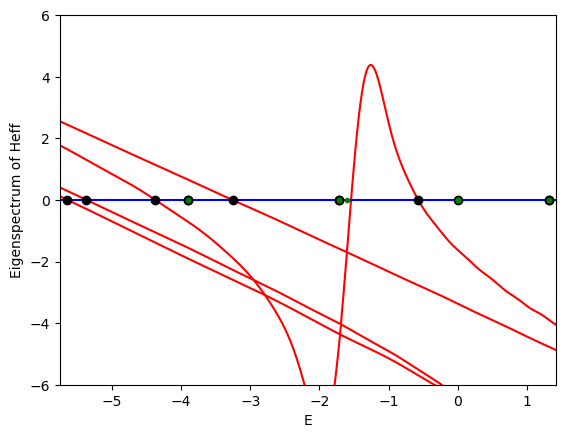

In [17]:
plt.xlabel('E')
plt.ylabel('Eigenspectrum of Heff')
plt.xlim(Xlim[0], Xlim[1])
# plt.xlim(4, 7)
plt.ylim(-6, 6)

for Eigenbranch in Eigenbranches:
    plt.plot(Energy, Eigenbranch, 'red')

plt.axhline(y=0, color='blue')

plt.plot(H_reduced_eigvals, jnp.zeros_like(H_reduced_eigvals), 'o', color='black')
plt.plot(QHQ_eigvals, jnp.zeros_like(QHQ_eigvals), 'o', color='green', markersize=3)

plt.show()

# Binary search 
### ($\Delta U = 0.4$)

## error $ = 10^{-3}$

In [18]:
kappa = 80
error = 3
file_name = f'coef_kappa{kappa}_error1e-{error}*'
file = glob.glob(file_name)
pcoefs = loadmat(file[0])
pcoefs = pcoefs['coef_full']

pcoefs = jnp.array([coef[0] for coef in pcoefs])
poly = Chebyshev(pcoefs)

In [19]:
U_sweep = jnp.linspace(0, U, 11)

In [20]:
solved_eigvals = [[vals.item() for vals in H0_eigvals_updated]]

def binary_search_solver(Schur_complement, x0, subspace_eigvals_idx, E_cutoff=10**(-error), max_iter=100):

    def f(x):
        Schur = Schur_complement(x)
        sub_eigvals = jnp.linalg.eigvalsh(Schur)
        return sub_eigvals[subspace_eigvals_idx]

    xn = x0[subspace_eigvals_idx]
    fn = f(x0[subspace_eigvals_idx])

    # Iterative binary search
    for iteration in range(max_iter):
        # Update bounds based on fn's sign
        if fn < 0:
            upper_bound = xn
            lower_bound = fn + xn
        else:
            upper_bound = fn + xn
            lower_bound = xn

        # Update midpoint
        xn = (lower_bound + upper_bound) / 2

        # Update the function value at xn
        fn = f(xn)

        # Check for convergence
        if jnp.abs(fn) < E_cutoff:
            print(f"Converged in {iteration} iterations.")
            print(xn)
            return xn.item()

    print("Binary search did not converge within the maximum number of iterations.")
    print(xn)
    return xn.item()


for i, UU in enumerate(U_sweep):
    # Skip the first iteration
    if i == 0:
        continue
    print('solve:', i)
    
    # Construct the Hamiltonian for the coulomb = U
    H = reduced_hubbard_model(U=float(UU), indices=reduced_H_indices)
    
    # Use binary search to solve the eigenvalues of different band
    solved_eigval = []
    for subspace_eigvals_idx in range(k):
        subspace_solved_eigval = binary_search_solver(Schur_complement=lambda x: Schur_complement_qsp(H=H, E=x, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim, poly=poly, kappa=kappa), 
                                                x0=solved_eigvals[-1], subspace_eigvals_idx=subspace_eigvals_idx)
        solved_eigval.append(subspace_solved_eigval)
    solved_eigvals.append(solved_eigval)
solved_eigvals = jnp.array(solved_eigvals).T

solve: 1
Converged in 8 iterations.
-7.7086248420164605
Converged in 8 iterations.
-7.703745411804083
Converged in 8 iterations.
-7.51236092262959
Converged in 8 iterations.
-7.504048130482363
solve: 2
Converged in 8 iterations.
-7.430972583869874
Converged in 8 iterations.
-7.413469914934003
Converged in 8 iterations.
-7.04801961178322
Converged in 8 iterations.
-7.012790142472712
solve: 3
Converged in 7 iterations.
-7.168579381757359
Converged in 8 iterations.
-7.1306198724380305
Converged in 8 iterations.
-6.610626320683613
Converged in 8 iterations.
-6.527115976796775
solve: 4
Converged in 7 iterations.
-6.921782965024387
Converged in 8 iterations.
-6.854779805490724
Converged in 8 iterations.
-6.202774645821927
Converged in 8 iterations.
-6.047577241011842
solve: 5
Converged in 7 iterations.
-6.686366559876175
Converged in 8 iterations.
-6.585372116768641
Converged in 7 iterations.
-5.825288841500781
Converged in 8 iterations.
-5.572719333207683
solve: 6
Converged in 7 iterations.

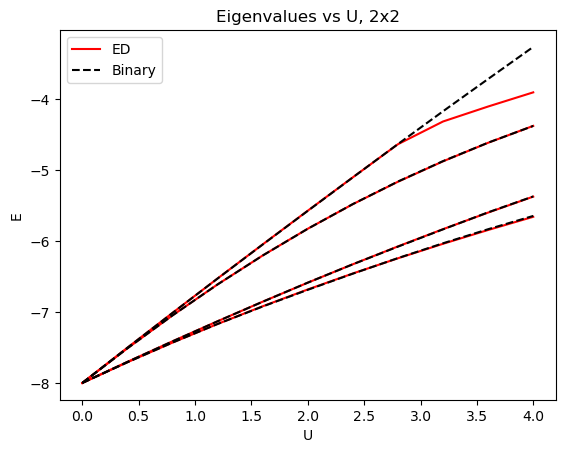

In [22]:
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 3):
    plt.plot(U_sweep_ED, H_eigvals_sweep[band], 'red')
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep, solved_eigvals[band], 'black', linestyle='dashed')

plt.plot(U_sweep_ED[0], H_eigvals_sweep[band][0], 'red', label='ED')
plt.plot(U_sweep[0], solved_eigvals[0, 0], 'black', linestyle='dashed', label='Binary')

plt.xlabel('U')
plt.ylabel('E')
plt.title(f'Eigenvalues vs U, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

plt.legend()
plt.show()

In [23]:
print(solved_eigvals.T[-1, 0]-H_eigvals_sweep.T[-1, 0])
print(solved_eigvals.T[-1, 1]-H_eigvals_sweep.T[-1, 1])
print(solved_eigvals.T[-1, 2]-H_eigvals_sweep.T[-1, 2])
print(solved_eigvals.T[-1, 3]-H_eigvals_sweep.T[-1, 5])

0.012558649033845626
0.0023313494628123266
-0.000640279165754265
-0.005843271496500435


## error $ = 10^{-6}$

In [24]:
kappa = 80
error = 6
file_name = f'coef_kappa{kappa}_error1e-{error}*'
file = glob.glob(file_name)
pcoefs = loadmat(file[0])
pcoefs = pcoefs['coef_full']

pcoefs = jnp.array([coef[0] for coef in pcoefs])
poly = Chebyshev(pcoefs)

In [25]:
U_sweep = jnp.linspace(0, U, 11)

In [26]:
solved_eigvals = [[vals.item() for vals in H0_eigvals_updated]]

def binary_search_solver(Schur_complement, x0, subspace_eigvals_idx, E_cutoff=10**(-error), max_iter=100):

    def f(x):
        Schur = Schur_complement(x)
        sub_eigvals = jnp.linalg.eigvalsh(Schur)
        return sub_eigvals[subspace_eigvals_idx]

    xn = x0[subspace_eigvals_idx]
    fn = f(x0[subspace_eigvals_idx])

    # Iterative binary search
    for iteration in range(max_iter):
        # Update bounds based on fn's sign
        if fn < 0:
            upper_bound = xn
            lower_bound = fn + xn
        else:
            upper_bound = fn + xn
            lower_bound = xn

        # Update midpoint
        xn = (lower_bound + upper_bound) / 2

        # Update the function value at xn
        fn = f(xn)

        # Check for convergence
        if jnp.abs(fn) < E_cutoff:
            print(f"Converged in {iteration} iterations.")
            print(xn)
            return xn.item()

    print("Binary search did not converge within the maximum number of iterations.")
    print(xn)
    return xn.item()


for i, UU in enumerate(U_sweep):
    # Skip the first iteration
    if i == 0:
        continue
    print('solve:', i)
    
    # Construct the Hamiltonian for the coulomb = U
    H = reduced_hubbard_model(U=float(UU), indices=reduced_H_indices)
    
    # Use binary search to solve the eigenvalues of different band
    solved_eigval = []
    for subspace_eigvals_idx in range(k):
        subspace_solved_eigval = binary_search_solver(Schur_complement=lambda x: Schur_complement_qsp(H=H, E=x, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim, poly=poly, kappa=kappa), 
                                                x0=solved_eigvals[-1], subspace_eigvals_idx=subspace_eigvals_idx)
        solved_eigval.append(subspace_solved_eigval)
    solved_eigvals.append(solved_eigval)
solved_eigvals = jnp.array(solved_eigvals).T

solve: 1
Converged in 18 iterations.
-7.707941101101285
Converged in 18 iterations.
-7.703188151295387
Converged in 18 iterations.
-7.511380210670351
Converged in 18 iterations.
-7.50306359140294
solve: 2
Converged in 17 iterations.
-7.43104984510987
Converged in 18 iterations.
-7.413002094937705
Converged in 18 iterations.
-7.047287051104327
Converged in 18 iterations.
-7.012005090875999
solve: 3
Converged in 17 iterations.
-7.168319739802248
Converged in 18 iterations.
-7.129816068244978
Converged in 18 iterations.
-6.610247003036401
Converged in 18 iterations.
-6.526460097386612
solve: 4
Converged in 17 iterations.
-6.918814772642771
Converged in 17 iterations.
-6.854000218490847
Converged in 17 iterations.
-6.202359421751161
Converged in 18 iterations.
-6.046080588022106
solve: 5
Converged in 17 iterations.
-6.681695030799941
Converged in 17 iterations.
-6.58590245181625
Converged in 16 iterations.
-5.824945328591174
Converged in 18 iterations.
-5.5705211654787545
solve: 6
Converge

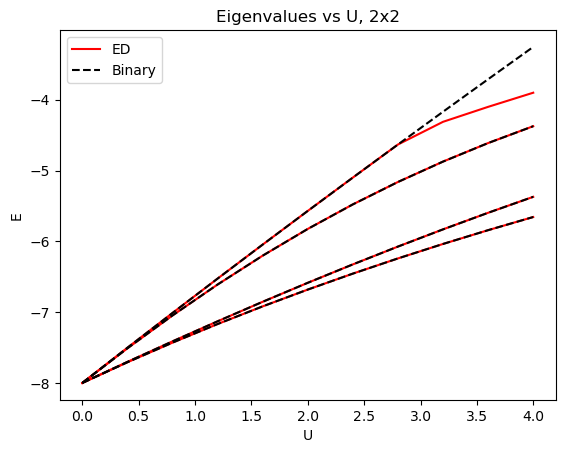

In [28]:
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 3):
    plt.plot(U_sweep_ED, H_eigvals_sweep[band], 'red')
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep, solved_eigvals[band], 'black', linestyle='dashed')

plt.plot(U_sweep_ED[0], H_eigvals_sweep[band][0], 'red', label='ED')
plt.plot(U_sweep[0], solved_eigvals[0, 0], 'black', linestyle='dashed', label='Binary')

plt.xlabel('U')
plt.ylabel('E')
plt.title(f'Eigenvalues vs U, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

plt.legend()
plt.show()

In [29]:
print(solved_eigvals.T[-1, 0]-H_eigvals_sweep.T[-1, 0])
print(solved_eigvals.T[-1, 1]-H_eigvals_sweep.T[-1, 1])
print(solved_eigvals.T[-1, 2]-H_eigvals_sweep.T[-1, 2])
print(solved_eigvals.T[-1, 3]-H_eigvals_sweep.T[-1, 5])

1.4625135400514466e-05
-5.48992707916085e-06
-1.7226664184022411e-06
-5.78248626759148e-06


## error $ = 10^{-8}$

In [30]:
kappa = 80
error = 8
file_name = f'coef_kappa{kappa}_error1e-{error}*'
file = glob.glob(file_name)
pcoefs = loadmat(file[0])
pcoefs = pcoefs['coef_full']

pcoefs = jnp.array([coef[0] for coef in pcoefs])
poly = Chebyshev(pcoefs)

In [31]:
U_sweep = jnp.linspace(0, U, 11)

In [32]:
solved_eigvals = [[vals.item() for vals in H0_eigvals_updated]]

def binary_search_solver(Schur_complement, x0, subspace_eigvals_idx, E_cutoff=10**(-error), max_iter=100):

    def f(x):
        Schur = Schur_complement(x)
        sub_eigvals = jnp.linalg.eigvalsh(Schur)
        return sub_eigvals[subspace_eigvals_idx]

    xn = x0[subspace_eigvals_idx]
    fn = f(x0[subspace_eigvals_idx])

    # Iterative binary search
    for iteration in range(max_iter):
        # Update bounds based on fn's sign
        if fn < 0:
            upper_bound = xn
            lower_bound = fn + xn
        else:
            upper_bound = fn + xn
            lower_bound = xn

        # Update midpoint
        xn = (lower_bound + upper_bound) / 2

        # Update the function value at xn
        fn = f(xn)

        # Check for convergence
        if jnp.abs(fn) < E_cutoff:
            print(f"Converged in {iteration} iterations.")
            print(xn)
            return xn.item()

    print("Binary search did not converge within the maximum number of iterations.")
    print(xn)
    return xn.item()


for i, UU in enumerate(U_sweep):
    # Skip the first iteration
    if i == 0:
        continue
    print('solve:', i)
    
    # Construct the Hamiltonian for the coulomb = U
    H = reduced_hubbard_model(U=float(UU), indices=reduced_H_indices)
    
    # Use binary search to solve the eigenvalues of different band
    solved_eigval = []
    for subspace_eigvals_idx in range(k):
        subspace_solved_eigval = binary_search_solver(Schur_complement=lambda x: Schur_complement_qsp(H=H, E=x, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim, poly=poly, kappa=kappa), 
                                                x0=solved_eigvals[-1], subspace_eigvals_idx=subspace_eigvals_idx)
        solved_eigval.append(subspace_solved_eigval)
    solved_eigvals.append(solved_eigval)
solved_eigvals = jnp.array(solved_eigvals).T

solve: 1
Converged in 24 iterations.
-7.707940517381385
Converged in 24 iterations.
-7.703187639195043
Converged in 25 iterations.
-7.5113794851943645
Converged in 25 iterations.
-7.503062715948755
solve: 2
Converged in 24 iterations.
-7.431049424341001
Converged in 24 iterations.
-7.413001410268651
Converged in 25 iterations.
-7.047286444714297
Converged in 25 iterations.
-7.0120039093938145
solve: 3
Converged in 24 iterations.
-7.168317405273312
Converged in 24 iterations.
-7.129815929162355
Converged in 24 iterations.
-6.610247216454145
Converged in 25 iterations.
-6.526459911988834
solve: 4
Converged in 24 iterations.
-6.9188159367677
Converged in 24 iterations.
-6.853998586721163
Converged in 23 iterations.
-6.202356374192549
Converged in 25 iterations.
-6.046078564744715
solve: 5
Converged in 23 iterations.
-6.681695240350743
Converged in 24 iterations.
-6.585902765939565
Converged in 22 iterations.
-5.824945905126288
Converged in 25 iterations.
-5.570521736535444
solve: 6
Conver

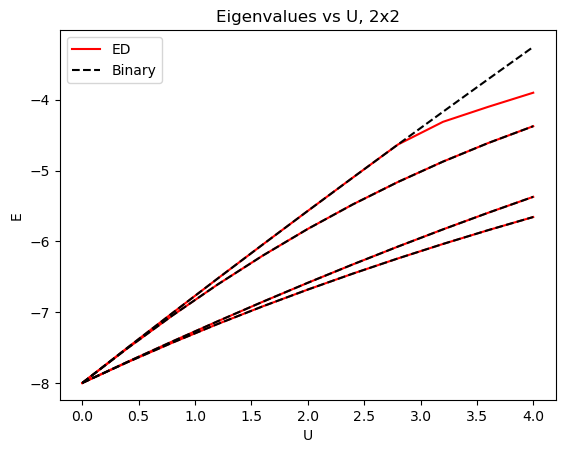

In [34]:
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 3):
    plt.plot(U_sweep_ED, H_eigvals_sweep[band], 'red')
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep, solved_eigvals[band], 'black', linestyle='dashed')

plt.plot(U_sweep_ED[0], H_eigvals_sweep[band][0], 'red', label='ED')
plt.plot(U_sweep[0], solved_eigvals[0, 0], 'black', linestyle='dashed', label='Binary')

plt.xlabel('U')
plt.ylabel('E')
plt.title(f'Eigenvalues vs U, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

plt.legend()
plt.show()

In [35]:
print(solved_eigvals.T[-1, 0]-H_eigvals_sweep.T[-1, 0])
print(solved_eigvals.T[-1, 1]-H_eigvals_sweep.T[-1, 1])
print(solved_eigvals.T[-1, 2]-H_eigvals_sweep.T[-1, 2])
print(solved_eigvals.T[-1, 3]-H_eigvals_sweep.T[-1, 5])

7.539023627600727e-09
6.489621284799796e-09
-7.994508166575542e-09
-1.0007559225755358e-08


## $\Delta U = 4$

## error $ = 10^{-3}$

In [74]:
kappa = 80
error = 3
file_name = f'coef_kappa{kappa}_error1e-{error}*'
file = glob.glob(file_name)
pcoefs = loadmat(file[0])
pcoefs = pcoefs['coef_full']

pcoefs = jnp.array([coef[0] for coef in pcoefs])
poly = Chebyshev(pcoefs)

In [75]:
U_sweep = jnp.linspace(0, U, 2)

In [76]:
solved_eigvals = [[vals.item() for vals in H0_eigvals_updated]]

def binary_search_solver(Schur_complement, x0, subspace_eigvals_idx, E_cutoff=10**(-error), max_iter=100):

    def f(x):
        Schur = Schur_complement(x)
        sub_eigvals = jnp.linalg.eigvalsh(Schur)
        return sub_eigvals[subspace_eigvals_idx]

    xn = x0[subspace_eigvals_idx]
    fn = f(x0[subspace_eigvals_idx])

    # Iterative binary search
    for iteration in range(max_iter):
        # Update bounds based on fn's sign
        if fn < 0:
            upper_bound = xn
            lower_bound = fn + xn
        else:
            upper_bound = fn + xn
            lower_bound = xn

        # Update midpoint
        xn = (lower_bound + upper_bound) / 2

        # Update the function value at xn
        fn = f(xn)

        # Check for convergence
        if jnp.abs(fn) < E_cutoff:
            print(f"Converged in {iteration} iterations.")
            print(xn)
            return xn.item()

    print("Binary search did not converge within the maximum number of iterations.")
    print(xn)
    return xn.item()


for i, UU in enumerate(U_sweep):
    # Skip the first iteration
    if i == 0:
        continue
    print('solve:', i)
    
    # Construct the Hamiltonian for the coulomb = U
    H = reduced_hubbard_model(U=float(UU), indices=reduced_H_indices)
    
    # Use binary search to solve the eigenvalues of different band
    solved_eigval = []
    for subspace_eigvals_idx in range(k):
        subspace_solved_eigval = binary_search_solver(Schur_complement=lambda x: Schur_complement_qsp(H=H, E=x, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim, poly=poly, kappa=kappa), 
                                                x0=solved_eigvals[-1], subspace_eigvals_idx=subspace_eigvals_idx)
        solved_eigval.append(subspace_solved_eigval)
    solved_eigvals.append(solved_eigval)
solved_eigvals = jnp.array(solved_eigvals).T

solve: 1
Converged in 10 iterations.
-5.643962609117427
Converged in 10 iterations.
-5.369525587721943
Converged in 7 iterations.
-4.374697047293655
Converged in 11 iterations.
-3.2604442812211367


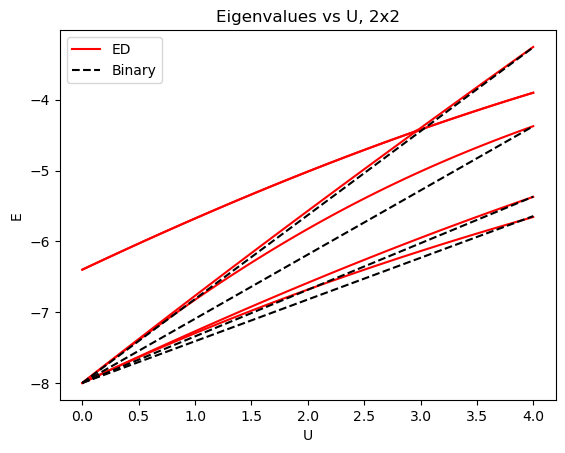

In [78]:
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 3):
    plt.plot(U_sweep_ED, H_eigvals_sweep[band], 'red')
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep, solved_eigvals[band], 'black', linestyle='dashed')

plt.plot(U_sweep_ED[0], H_eigvals_sweep[band][0], 'red', label='ED')
plt.plot(U_sweep[0], solved_eigvals[0, 0], 'black', linestyle='dashed', label='Binary')

plt.xlabel('U')
plt.ylabel('E')
plt.title(f'Eigenvalues vs U, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

plt.legend()
plt.show()

In [41]:
print(solved_eigvals.T[-1, 0]-H_eigvals_sweep.T[-1, 0])
print(solved_eigvals.T[-1, 1]-H_eigvals_sweep.T[-1, 1])
print(solved_eigvals.T[-1, 2]-H_eigvals_sweep.T[-1, 2])
print(solved_eigvals.T[-1, 3]-H_eigvals_sweep.T[-1, 5])

0.012891640374952829
0.0021667433867351704
-0.0005592280170372277
-0.006018270627811795


# Wegstien's method
### ($\Delta U = 0.4$)

## error $ = 10^{-3}$

In [42]:
kappa = 80
error = 3
file_name = f'coef_kappa{kappa}_error1e-{error}*'
file = glob.glob(file_name)
pcoefs = loadmat(file[0])
pcoefs = pcoefs['coef_full']

pcoefs = jnp.array([coef[0] for coef in pcoefs])
poly = Chebyshev(pcoefs)

In [43]:
U_sweep = jnp.linspace(0, U, 11)

In [44]:
solved_eigvals = [[vals.item() for vals in H0_eigvals_updated]]

def Wegstein_solver(Schur_complement, x0, subspace_eigvals_idx, E_cutoff=10**(-error), max_iter=100):

    def f(x):
        Schur = Schur_complement(x)
        sub_eigvals = jnp.linalg.eigvalsh(Schur)
        return sub_eigvals[subspace_eigvals_idx] + x
    
    # Initialize xn and fn
    xn = [x0[subspace_eigvals_idx], f(x0[subspace_eigvals_idx])]
    fn = [xn[1], f(xn[1])]    
    
    for i in range(1, max_iter):
        
        x_new = (xn[i-1]*fn[i] - xn[i]*fn[i-1]) / (xn[i-1] + fn[i] - xn[i] - fn[i-1])
        xn.append(x_new)
        fn.append(f(x_new))
        
        # If the energy difference is less than cutoff, the algorithm converge
        if abs(x_new - xn[i]) < E_cutoff:
            print(f"Converged in {i} iterations.")
            print(fn[-1])
            return fn[-1]
    
    print("Wegstein method did not converge within the maximum number of iterations.")
    print(fn[-1])   
    return fn[-1]


for i, UU in enumerate(U_sweep):
    # Skip the first iteration
    if i == 0:
        continue
    print('solve:', i)
    
    # Construct the Hamiltonian for the coulomb = U
    H = reduced_hubbard_model(U=float(UU), indices=reduced_H_indices)
    
    # Use binary search to solve the eigenvalues of different band
    solved_eigval = []
    for subspace_eigvals_idx in range(k):
        subspace_solved_eigval = Wegstein_solver(Schur_complement=lambda x: Schur_complement_qsp(H=H, E=x, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim, poly=poly, kappa=kappa), 
                                                x0=solved_eigvals[-1], subspace_eigvals_idx=subspace_eigvals_idx)
        solved_eigval.append(subspace_solved_eigval)
    solved_eigvals.append(solved_eigval)
solved_eigvals = jnp.array(solved_eigvals).T

solve: 1
Converged in 1 iterations.
-7.708061038770026
Converged in 1 iterations.
-7.703166912386917
Converged in 2 iterations.
-7.511429256463924
Converged in 1 iterations.
-7.503080822418583
solve: 2
Converged in 2 iterations.
-7.430449365759499
Converged in 1 iterations.
-7.412913521403527
Converged in 2 iterations.
-7.047200099459271
Converged in 1 iterations.
-7.011846631381325
solve: 3
Converged in 2 iterations.
-7.167590572562192
Converged in 2 iterations.
-7.130090742392528
Converged in 2 iterations.
-6.609946904114455
Converged in 2 iterations.
-6.526194494672732
solve: 4
Converged in 2 iterations.
-6.920889388451731
Converged in 2 iterations.
-6.854257509397514
Converged in 2 iterations.
-6.202247891016215
Converged in 2 iterations.
-6.046661419765832
solve: 5
Converged in 2 iterations.
-6.685595265586447
Converged in 2 iterations.
-6.584873250036493
Converged in 2 iterations.
-5.824518175699842
Converged in 2 iterations.
-5.571815615907269
solve: 6
Converged in 2 iterations.

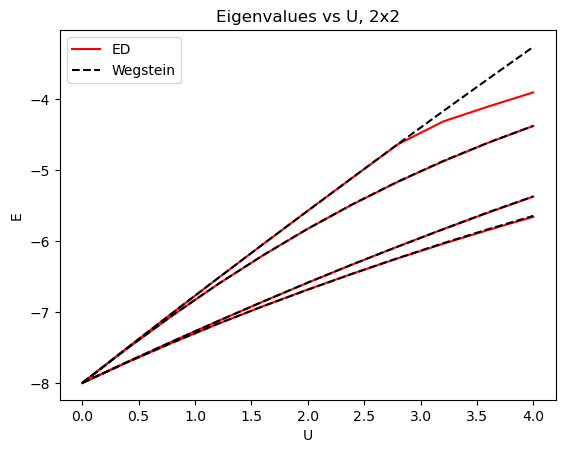

In [46]:
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 3):
    plt.plot(U_sweep_ED, H_eigvals_sweep[band], 'red')
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep, solved_eigvals[band], 'black', linestyle='dashed')

plt.plot(U_sweep_ED[0], H_eigvals_sweep[band][0], 'red', label='ED')
plt.plot(U_sweep[0], solved_eigvals[0, 0], 'black', linestyle='dashed', label='Wegstein')

plt.xlabel('U')
plt.ylabel('E')
plt.title(f'Eigenvalues vs U, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

plt.legend()
plt.show()

In [47]:
print(solved_eigvals.T[-1, 0]-H_eigvals_sweep.T[-1, 0])
print(solved_eigvals.T[-1, 1]-H_eigvals_sweep.T[-1, 1])
print(solved_eigvals.T[-1, 2]-H_eigvals_sweep.T[-1, 2])
print(solved_eigvals.T[-1, 3]-H_eigvals_sweep.T[-1, 5])

0.013425654596753489
0.0028682710925709287
-0.0003842700776424124
-0.0050390361485086466


## error $ = 10^{-6}$

In [48]:
kappa = 80
error = 6
file_name = f'coef_kappa{kappa}_error1e-{error}*'
file = glob.glob(file_name)
pcoefs = loadmat(file[0])
pcoefs = pcoefs['coef_full']

pcoefs = jnp.array([coef[0] for coef in pcoefs])
poly = Chebyshev(pcoefs)

In [49]:
U_sweep = jnp.linspace(0, U, 11)

In [50]:
solved_eigvals = [[vals.item() for vals in H0_eigvals_updated]]

def Wegstein_solver(Schur_complement, x0, subspace_eigvals_idx, E_cutoff=10**(-error), max_iter=100):

    def f(x):
        Schur = Schur_complement(x)
        sub_eigvals = jnp.linalg.eigvalsh(Schur)
        return sub_eigvals[subspace_eigvals_idx] + x
    
    # Initialize xn and fn
    xn = [x0[subspace_eigvals_idx], f(x0[subspace_eigvals_idx])]
    fn = [xn[1], f(xn[1])]    
    
    for i in range(1, max_iter):
        
        x_new = (xn[i-1]*fn[i] - xn[i]*fn[i-1]) / (xn[i-1] + fn[i] - xn[i] - fn[i-1])
        xn.append(x_new)
        fn.append(f(x_new))
        
        # If the energy difference is less than cutoff, the algorithm converge
        if abs(x_new - xn[i]) < E_cutoff:
            print(f"Converged in {i} iterations.")
            print(fn[-1])
            return fn[-1]
    
    print("Wegstein method did not converge within the maximum number of iterations.")
    print(fn[-1])   
    return fn[-1]


for i, UU in enumerate(U_sweep):
    # Skip the first iteration
    if i == 0:
        continue
    print('solve:', i)
    
    # Construct the Hamiltonian for the coulomb = U
    H = reduced_hubbard_model(U=float(UU), indices=reduced_H_indices)
    
    # Use binary search to solve the eigenvalues of different band
    solved_eigval = []
    for subspace_eigvals_idx in range(k):
        subspace_solved_eigval = Wegstein_solver(Schur_complement=lambda x: Schur_complement_qsp(H=H, E=x, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim, poly=poly, kappa=kappa), 
                                                x0=solved_eigvals[-1], subspace_eigvals_idx=subspace_eigvals_idx)
        solved_eigval.append(subspace_solved_eigval)
    solved_eigvals.append(solved_eigval)
solved_eigvals = jnp.array(solved_eigvals).T

solve: 1
Converged in 2 iterations.
-7.70794055371979
Converged in 2 iterations.
-7.703187589073152
Converged in 2 iterations.
-7.51137932417193
Converged in 2 iterations.
-7.503062649602413
solve: 2
Converged in 2 iterations.
-7.4310488535583685
Converged in 2 iterations.
-7.413001557141077
Converged in 3 iterations.
-7.047286340721803
Converged in 2 iterations.
-7.012004176997252
solve: 3
Converged in 2 iterations.
-7.168318864559859
Converged in 2 iterations.
-7.1298155632122455
Converged in 3 iterations.
-6.61024651861214
Converged in 2 iterations.
-6.526459219183625
solve: 4
Converged in 3 iterations.
-6.918814016804712
Converged in 2 iterations.
-6.853999282947076
Converged in 3 iterations.
-6.20235884798512
Converged in 2 iterations.
-6.046079751451791
solve: 5
Converged in 3 iterations.
-6.68169438969476
Converged in 2 iterations.
-6.585901606422014
Converged in 3 iterations.
-5.824944746017667
Converged in 3 iterations.
-5.570520374024893
solve: 6
Converged in 3 iterations.
-6

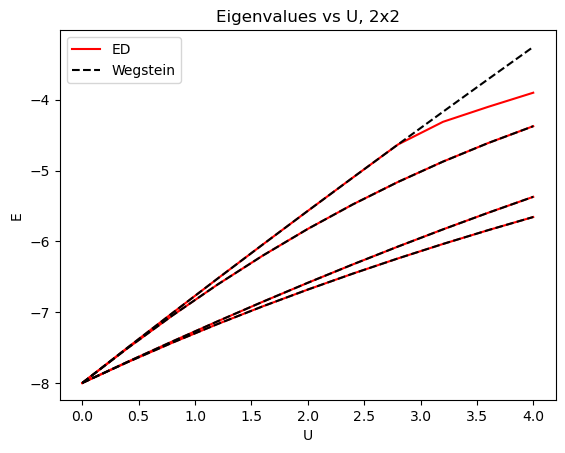

In [52]:
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 3):
    plt.plot(U_sweep_ED, H_eigvals_sweep[band], 'red')
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep, solved_eigvals[band], 'black', linestyle='dashed')

plt.plot(U_sweep_ED[0], H_eigvals_sweep[band][0], 'red', label='ED')
plt.plot(U_sweep[0], solved_eigvals[0, 0], 'black', linestyle='dashed', label='Wegstein')

plt.xlabel('U')
plt.ylabel('E')
plt.title(f'Eigenvalues vs U, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

plt.legend()
plt.show()

In [53]:
print(solved_eigvals.T[-1, 0]-H_eigvals_sweep.T[-1, 0])
print(solved_eigvals.T[-1, 1]-H_eigvals_sweep.T[-1, 1])
print(solved_eigvals.T[-1, 2]-H_eigvals_sweep.T[-1, 2])
print(solved_eigvals.T[-1, 3]-H_eigvals_sweep.T[-1, 5])

1.5106167773559775e-05
-4.757406466993075e-06
-1.3655785497945772e-06
-5.228180555594264e-06


## error $ = 10^{-8}$

In [54]:
kappa = 80
error = 8
file_name = f'coef_kappa{kappa}_error1e-{error}*'
file = glob.glob(file_name)
pcoefs = loadmat(file[0])
pcoefs = pcoefs['coef_full']

pcoefs = jnp.array([coef[0] for coef in pcoefs])
poly = Chebyshev(pcoefs)

In [55]:
U_sweep = jnp.linspace(0, U, 11)

In [56]:
solved_eigvals = [[vals.item() for vals in H0_eigvals_updated]]

def Wegstein_solver(Schur_complement, x0, subspace_eigvals_idx, E_cutoff=10**(-error), max_iter=100):

    def f(x):
        Schur = Schur_complement(x)
        sub_eigvals = jnp.linalg.eigvalsh(Schur)
        return sub_eigvals[subspace_eigvals_idx] + x
    
    # Initialize xn and fn
    xn = [x0[subspace_eigvals_idx], f(x0[subspace_eigvals_idx])]
    fn = [xn[1], f(xn[1])]    
    
    for i in range(1, max_iter):
        
        x_new = (xn[i-1]*fn[i] - xn[i]*fn[i-1]) / (xn[i-1] + fn[i] - xn[i] - fn[i-1])
        xn.append(x_new)
        fn.append(f(x_new))
        
        # If the energy difference is less than cutoff, the algorithm converge
        if abs(x_new - xn[i]) < E_cutoff:
            print(f"Converged in {i} iterations.")
            print(fn[-1])
            return fn[-1]
    
    print("Wegstein method did not converge within the maximum number of iterations.")
    print(fn[-1])   
    return fn[-1]


for i, UU in enumerate(U_sweep):
    # Skip the first iteration
    if i == 0:
        continue
    print('solve:', i)
    
    # Construct the Hamiltonian for the coulomb = U
    H = reduced_hubbard_model(U=float(UU), indices=reduced_H_indices)
    
    # Use binary search to solve the eigenvalues of different band
    solved_eigval = []
    for subspace_eigvals_idx in range(k):
        subspace_solved_eigval = Wegstein_solver(Schur_complement=lambda x: Schur_complement_qsp(H=H, E=x, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim, poly=poly, kappa=kappa), 
                                                x0=solved_eigvals[-1], subspace_eigvals_idx=subspace_eigvals_idx)
        solved_eigval.append(subspace_solved_eigval)
    solved_eigvals.append(solved_eigval)
solved_eigvals = jnp.array(solved_eigvals).T

solve: 1
Converged in 2 iterations.
-7.70794050887608
Converged in 2 iterations.
-7.703187630429572
Converged in 3 iterations.
-7.511379478412543
Converged in 2 iterations.
-7.503062708608359
solve: 2
Converged in 33 iterations.
-7.4310494166734395
Converged in 5 iterations.
-7.413001401975185
Converged in 3 iterations.
-7.047286439594287
Converged in 22 iterations.
-7.012003902334738
solve: 3
Converged in 3 iterations.
-7.168317398853692
Converged in 4 iterations.
-7.12981592138835
Converged in 3 iterations.
-6.610247210091392
Converged in 12 iterations.
-6.526459905228895
solve: 4
Converged in 3 iterations.
-6.918815931379194
Converged in 3 iterations.
-6.853998579690377
Converged in 12 iterations.
-6.2023563721063475
Converged in 3 iterations.
-6.046078558469684
solve: 5
Converged in 3 iterations.
-6.681695231348522
Converged in 3 iterations.
-6.58590275978474
Converged in 4 iterations.
-5.824945900822618
Converged in 3 iterations.
-5.57052173060931
solve: 6
Converged in 3 iteration

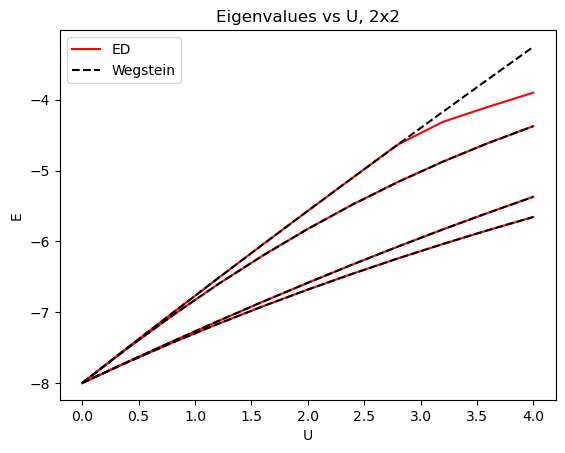

In [58]:
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 3):
    plt.plot(U_sweep_ED, H_eigvals_sweep[band], 'red')
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep, solved_eigvals[band], 'black', linestyle='dashed')

plt.plot(U_sweep_ED[0], H_eigvals_sweep[band][0], 'red', label='ED')
plt.plot(U_sweep[0], solved_eigvals[0, 0], 'black', linestyle='dashed', label='Wegstein')

plt.xlabel('U')
plt.ylabel('E')
plt.title(f'Eigenvalues vs U, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

plt.legend()
plt.show()

In [59]:
print(solved_eigvals.T[-1, 0]-H_eigvals_sweep.T[-1, 0])
print(solved_eigvals.T[-1, 1]-H_eigvals_sweep.T[-1, 1])
print(solved_eigvals.T[-1, 2]-H_eigvals_sweep.T[-1, 2])
print(solved_eigvals.T[-1, 3]-H_eigvals_sweep.T[-1, 5])

1.2624236767067032e-08
1.4937777237378214e-08
-5.412077008770666e-09
-2.4953474841993284e-09


## $\Delta U = 4$

## error $ = 10^{-3}$

In [79]:
kappa = 80
error = 3
file_name = f'coef_kappa{kappa}_error1e-{error}*'
file = glob.glob(file_name)
pcoefs = loadmat(file[0])
pcoefs = pcoefs['coef_full']

pcoefs = jnp.array([coef[0] for coef in pcoefs])
poly = Chebyshev(pcoefs)

In [80]:
U_sweep = jnp.linspace(0, U, 2)

In [81]:
solved_eigvals = [[vals.item() for vals in H0_eigvals_updated]]

def Wegstein_solver(Schur_complement, x0, subspace_eigvals_idx, E_cutoff=10**(-error), max_iter=100):

    def f(x):
        Schur = Schur_complement(x)
        sub_eigvals = jnp.linalg.eigvalsh(Schur)
        return sub_eigvals[subspace_eigvals_idx] + x
    
    # Initialize xn and fn
    xn = [x0[subspace_eigvals_idx], f(x0[subspace_eigvals_idx])]
    fn = [xn[1], f(xn[1])]    
    
    for i in range(1, max_iter):
        
        x_new = (xn[i-1]*fn[i] - xn[i]*fn[i-1]) / (xn[i-1] + fn[i] - xn[i] - fn[i-1])
        xn.append(x_new)
        fn.append(f(x_new))
        
        # If the energy difference is less than cutoff, the algorithm converge
        if abs(x_new - xn[i]) < E_cutoff:
            print(f"Converged in {i} iterations.")
            print(fn[-1])
            return fn[-1]
    
    print("Wegstein method did not converge within the maximum number of iterations.")
    print(fn[-1])   
    return fn[-1]


for i, UU in enumerate(U_sweep):
    # Skip the first iteration
    if i == 0:
        continue
    print('solve:', i)
    
    # Construct the Hamiltonian for the coulomb = U
    H = reduced_hubbard_model(U=float(UU), indices=reduced_H_indices)
    
    # Use binary search to solve the eigenvalues of different band
    solved_eigval = []
    for subspace_eigvals_idx in range(k):
        subspace_solved_eigval = Wegstein_solver(Schur_complement=lambda x: Schur_complement_qsp(H=H, E=x, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim, poly=poly, kappa=kappa), 
                                                x0=solved_eigvals[-1], subspace_eigvals_idx=subspace_eigvals_idx)
        solved_eigval.append(subspace_solved_eigval)
    solved_eigvals.append(solved_eigval)
solved_eigvals = jnp.array(solved_eigvals).T

solve: 1
Converged in 3 iterations.
-5.643428595821264
Converged in 3 iterations.
-5.368824061746548
Converged in 4 iterations.
-4.374522071384849
Converged in 3 iterations.
-3.259465047454348


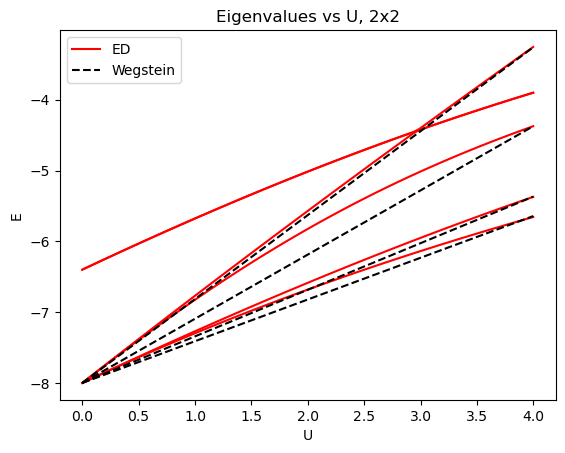

In [83]:
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 3):
    plt.plot(U_sweep_ED, H_eigvals_sweep[band], 'red')
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep, solved_eigvals[band], 'black', linestyle='dashed')

plt.plot(U_sweep_ED[0], H_eigvals_sweep[band][0], 'red', label='ED')
plt.plot(U_sweep[0], solved_eigvals[0, 0], 'black', linestyle='dashed', label='Wegstein')

plt.xlabel('U')
plt.ylabel('E')
plt.title(f'Eigenvalues vs U, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

plt.legend()
plt.show()

In [84]:
print(solved_eigvals.T[-1, 0]-H_eigvals_sweep.T[-1, 0])
print(solved_eigvals.T[-1, 1]-H_eigvals_sweep.T[-1, 1])
print(solved_eigvals.T[-1, 2]-H_eigvals_sweep.T[-1, 2])
print(solved_eigvals.T[-1, 3]-H_eigvals_sweep.T[-1, 5])

0.013425653671115256
0.002868269362130249
-0.0003842521082315642
-0.005039036861023138
